In [1]:
import sys 
sys.path.insert(0,'../')

%matplotlib inline
from scripts.Deblender import Deblend
from scripts.utils import listdir_fullpath

import numpy as np
import os

import matplotlib.pyplot as plt

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import tensorflow as tf
import tensorflow_probability as tfp
tf.get_logger().setLevel('ERROR')

2022-04-27 14:53:54.529734: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-04-27 14:53:54.529809: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [18]:
import seaborn as sns
sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

In [3]:
COSMOS_CATALOG_PATHS = [
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits",
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2_fits.fits",
]


stamp_size = 100
max_number = 60
batch_size = 1
max_shift = 44
catalog = btk.catalog.CosmosCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("Rubin")
seed=3

import galsim 
galsim_catalog = galsim.COSMOSCatalog(COSMOS_CATALOG_PATHS[0], exclusion_level="marginal")

sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number, maxshift=max_shift, stamp_size=stamp_size, seed=seed)

draw_generator = btk.draw_blends.CosmosGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    gal_type="parametric",
    seed=seed,
)

In [4]:
def crop_image(image, pos, cutout_size):
    """
    crops a portion of the image.
    
    Parameters
    ----------
    image:
    
    pos:
    
    cutout_size: float
        cutout size in arcminutes
    
    Returns
    -------
    cropped image
    """
    
    cutout_pixel_size = int(cutout_size * 5)
    
    x_crop_start = int(pos[0] - (cutout_pixel_size-1)/2)
    x_crop_end = int(pos[0] + (cutout_pixel_size-1)/2)
    
    y_crop_start = int(pos[1] - (cutout_pixel_size-1)/2)
    y_crop_end = int(pos[1] + (cutout_pixel_size-1)/2)
    
    #print(np.shape(image))
    #print(pos)
    #print(x_crop_start)
    #print(x_crop_end+1)
    cropped_image = image[2, x_crop_start:x_crop_end+1, y_crop_start:y_crop_end+1]
    
    #print(np.shape(crop_image))
    return cropped_image.copy()


In [5]:
blend = next(draw_generator)

blend['blend_list'][0]['x_peak']

np.shape(blend['blend_images'][0])

(6, 500, 500)

input_image


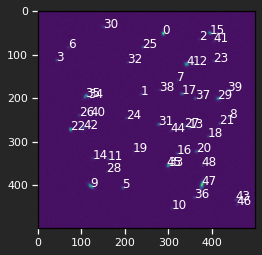

In [6]:
print("input_image")
plt.imshow(blend['blend_images'][0, 2])
for i in range(len(blend['blend_list'][0])):
    plt.text(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], str(i))

input_image


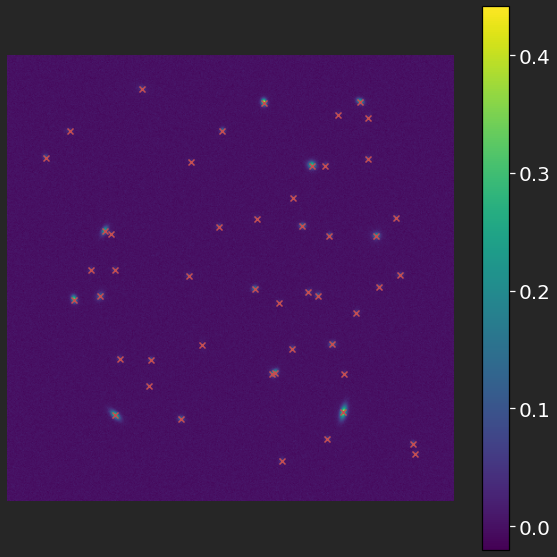

In [7]:
print("input_image")
fig=plt.figure(figsize=(10,10))
ax=fig.gca()
im1 = ax.imshow(blend['blend_images'][0, 2]/80000)
for i in range(len(blend['blend_list'][0])):
    plt.scatter(blend['blend_list'][0]['x_peak'][i], 
                blend['blend_list'][0]['y_peak'][i], marker="x", c="r")
    #plt.text(blend['blend_list'][0]['x_peak'][i]-1, blend['blend_list'][0]['y_peak'][i]-1, str(i), c='black', fontsize=15)
cbar = fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("input field")


In [8]:
tf.get_logger().setLevel('ERROR')

detected_positions = []
for i in range(len(blend['blend_list'][0])):
    detected_positions.append([blend['blend_list'][0]['y_peak'][i], blend['blend_list'][0]['x_peak'][i]])

deb = Deblend(blend['blend_images'][0]/80000, 
              detected_positions,
              latent_dim=8, 
              num_components=len(blend['blend_list'][0]), 
              use_likelihood=True, 
              max_iter=300)

2022-04-27 14:54:21.464924: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-04-27 14:54:21.465039: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-27 14:54:21.465103: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-04-27 14:54:21.465933: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-27 1

In [9]:
#deb.run_debvader()

In [10]:
#fig, ax = plt.subplots(len(blend['blend_list'][0]), 3, figsize=(5*3,5*len(blend['blend_list'][0])))

#for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
#     im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 9))
#     cbar = fig.colorbar(im1, ax=ax[i, 0])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 0].set_title("ground truth")
#     ax[i, 0].scatter(22, 22, c="r", marker="x")

#     im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i, 1])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 1].set_title("predicted")
    
#     im3 = ax[i, 2].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 9) - deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im3, ax=ax[i, 2])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 2].set_title("actual - predicted")
    
# plt.show()

In [11]:
# fig = plt.figure(figsize=(10,10))
# ax = fig.gca()
# padding_infos = deb.get_padding_infos()
# residual = deb.compute_residual(blend['blend_images'][0]/80000, use_scatter_and_sub=True).numpy()
# #residual = np.transpose(deb.postage_stamp, 
# im1 = ax.imshow(residual[:, :, 2])
# cbar =fig.colorbar(im1, ax=ax)
# cbar.ax.tick_params(labelsize=20)
# plt.savefig("residual")

In [12]:
tf.config.run_functions_eagerly(False)
convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(atol=.0000015*45*45*49*3, min_num_steps=50, window_size=20)
#convergence_criterion = None
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.04, decay_steps=12, decay_rate=0.75, staircase=True)
optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_scheduler)

deb(convergence_criterion, optimizer=optimizer)


--- Starting gradient descent in the latent space ---
Maximum number of iterations: 300
Number of Galaxies: 49
Dimensions of latent space: 8
--- Gradient descent complete ---

Time taken for gradient descent: 37.485960960388184


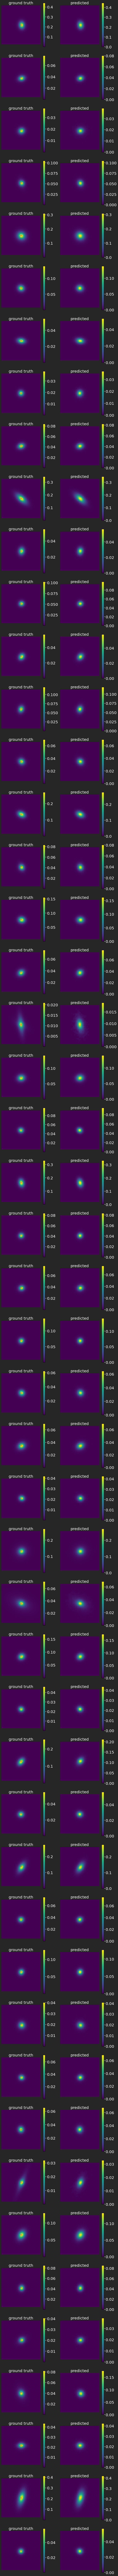

In [13]:
fig, ax = plt.subplots(len(blend['blend_list'][0]), 2, figsize=(5*2,5*len(blend['blend_list'][0])))

for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
    im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 9))
    cbar = fig.colorbar(im1, ax=ax[i, 0])
    cbar.ax.tick_params(labelsize=20)
    ax[i, 0].set_title("ground truth", fontsize=20)
    ax[i, 0].scatter(22, 22, c="r", marker="x")
    ax[i, 0].axis('off')


    im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i, 1])
    cbar.ax.tick_params(labelsize=20)
    ax[i, 1].set_title("predicted", fontsize=20)
    ax[i, 1].axis('off')

    
#     im3 = ax[i, 2].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 9) - deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im3, ax=ax[i, 2])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 2].set_title("actual - predicted")
#     plt.axis('off')

plt.savefig("MAP_predictions")
plt.show()

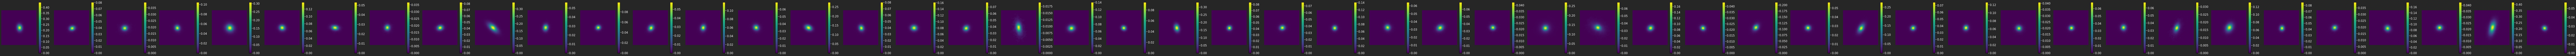

In [14]:
fig, ax = plt.subplots(1, len(blend['blend_list'][0]), figsize=(5*len(blend['blend_list'][0]), 5*1))
for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]

    im2 = ax[i].imshow(deb.components[i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i])
    cbar.ax.tick_params(labelsize=15)
    ax[i].axis("off")
    #ax[i].set_title("predicted")
plt.savefig("predictions")

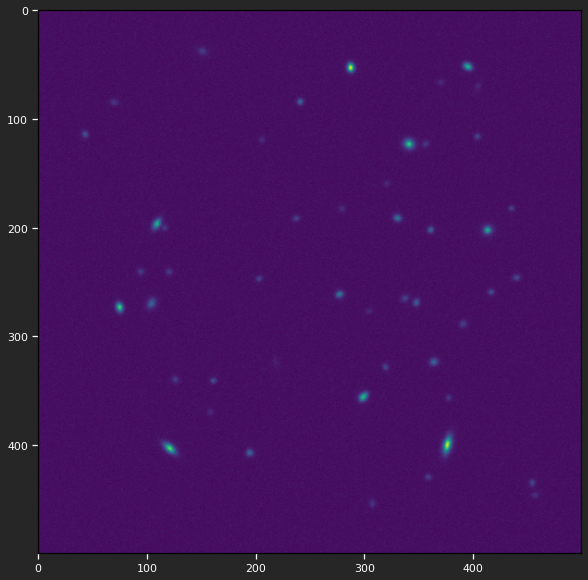

In [15]:
fig = plt.figure(figsize=(10,10))
plt.imshow(blend['blend_images'][0][1])

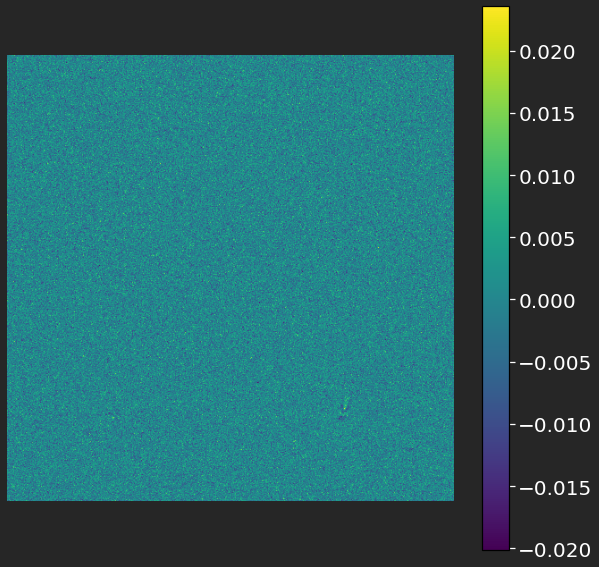

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
tf.config.run_functions_eagerly(True)

padding_infos = deb.get_padding_infos()
residual = deb.compute_residual(blend['blend_images'][0]/80000, use_scatter_and_sub=True).numpy()
#residual = np.transpose(deb.postage_stamp, 
im1 = ax.imshow(residual[:, :, 2])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("residual")

#for i in range(len(blend['blend_list'][0])):
    #plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", linewidths=.5, s=120, c="r")

tf.Tensor(
[750893.94 763711.25 752880.5  753320.7  753057.25 753436.5  752369.2
 752813.9  752072.6  752106.   751778.1  751559.6  751450.94 751088.4
 750915.9  750742.4  750643.9  750533.1  750543.4  750396.1  750403.1
 750346.3  750453.6  750360.2  750354.3  750285.1  750203.3  750122.
 750105.9  750048.2  750049.6  749997.06 750052.7  749971.4  750079.
 749976.1  750062.9  749941.3  749912.5  749887.6  749878.8  749857.3
 749853.25 749830.8  749842.8  749803.7  749870.44 749804.5  749874.6
 749777.9  749775.2  749753.25 749744.7  749731.8  749726.8  749716.75
 749717.75 749701.06 749697.6  749679.3  749692.7  749647.8  749657.
 749633.8  749634.44 749616.9  749613.5  749598.06 749595.8  749577.56
 749580.4  749560.1  749570.25 749543.9  749539.8  749528.4  749521.7
 749513.56 749505.75 749498.4  749492.2  749483.7  749480.5  749472.
 749471.   749453.5  749455.06 749444.25 749444.6  749436.1  749435.1
 749427.8  749426.7  749420.5  749420.8  749413.3  749418.06 749406.9
 749407.56 

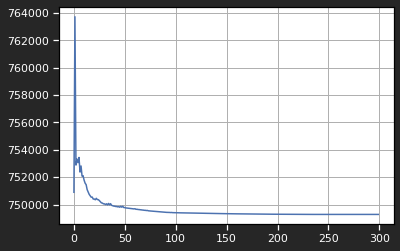

In [19]:
print(deb.results)
plt.plot(deb.results)